# Comparing SRTM DEM data to Copernicus DSM

Both the [SRTM](https://www2.jpl.nasa.gov/srtm/) and [Copernicus DEM (COP DEM)](https://spacedata.copernicus.eu/web/cscda/dataset-details?articleId=394198) are available through the `--data-source` command in `sardem`.

We can compare the two data sources over an interesting area, such as Hawaii.

In [23]:
# SRTM data
!sardem --bbox -156.000138888888 19.0001388888888 -155.000138888888 20.000138888888 -o elevation_srtm.dem

[08/15 12:21:33] [INFO dem.py] Bounds: -156.0 19.0 -155.0 20.0
[08/15 12:21:33] [INFO dem.py] Shifting bbox to nearest tile bounds
[08/15 12:21:33] [INFO dem.py] New edge bounds: -156.0001388888889 19.000138888888888 -155.0001388888889 20.000138888888888
[08/15 12:21:33] [INFO download.py] /Users/staniewi/.cache/sardem/N19W156.hgt already exists, skipping.
[08/15 12:21:33] [INFO dem.py] Cropping stitched DEM to boundaries
[08/15 12:21:33] [INFO dem.py] Rate = 1: No upsampling to do
[08/15 12:21:33] [INFO dem.py] Writing DEM to elevation_srtm.dem
[08/15 12:21:34] [INFO dem.py] Writing .dem.rsc file to elevation_srtm.dem.rsc
[08/15 12:21:34] [INFO dem.py] Correcting DEM to heights above WGS84 ellipsoid
[08/15 12:21:34] [INFO conversions.py] gdalwarp -overwrite -s_srs "epsg:4326+5773" -t_srs "epsg:4326" -of ENVI -ts 3600 3600  -multi -wo NUM_THREADS=4 -wm 4000 egm_elevation_srtm.dem elevation_srtm.dem
Creating output file that is 3600P x 3600L.
Processing egm_elevation_srtm.dem [1/1] : 0.

Now make the Copernicus version:

In [10]:
%%time
!sardem --bbox -156.000138888888 19.0001388888888 -155.000138888888 20.000138888888 -o elevation_cop.dem --data-source cop

[08/15 12:10:18] [INFO dem.py] Bounds: -156.0 19.0 -155.0 20.0
[08/15 12:10:18] [INFO dem.py] Shifting bbox to nearest tile bounds
[08/15 12:10:18] [INFO dem.py] New edge bounds: -156.0001388888889 19.000138888888888 -155.0001388888889 20.000138888888888
[08/15 12:10:18] [INFO cop_dem.py] Creating elevation_cop.dem
[08/15 12:10:18] [INFO cop_dem.py] Fetching remote tiles...
[08/15 12:10:18] [INFO cop_dem.py] Running GDAL command:
[08/15 12:10:18] [INFO cop_dem.py] gdalwarp /vsicurl/https://raw.githubusercontent.com/scottstanie/sardem/master/sardem/data/cop_global.vrt elevation_cop.dem -of ENVI -ot Int16 -te -156.000138888888898 19.0001388888888876 -155.000138888888898 20.0001388888888876 -tr 0.000277777777777777778 0.000277777777777777778 -s_srs "epsg:4326+3855" -t_srs "epsg:4326" -wo NUM_THREADS=4 -r nearest -wm 5000 -multi
Creating output file that is 3600P x 3600L.
0...10...20...30...40...50...60...70...80...90...100 - done.
CPU times: user 167 ms, sys: 65.2 ms, total: 232 ms
Wall t

In [10]:
from osgeo import gdal

ds = gdal.Open("elevation_srtm.dem")
dem_srtm = ds.GetRasterBand(1).ReadAsArray()
ds = None

ds = gdal.Open("elevation_cop.dem")
dem_cop = ds.GetRasterBand(1).ReadAsArray()
ds = None

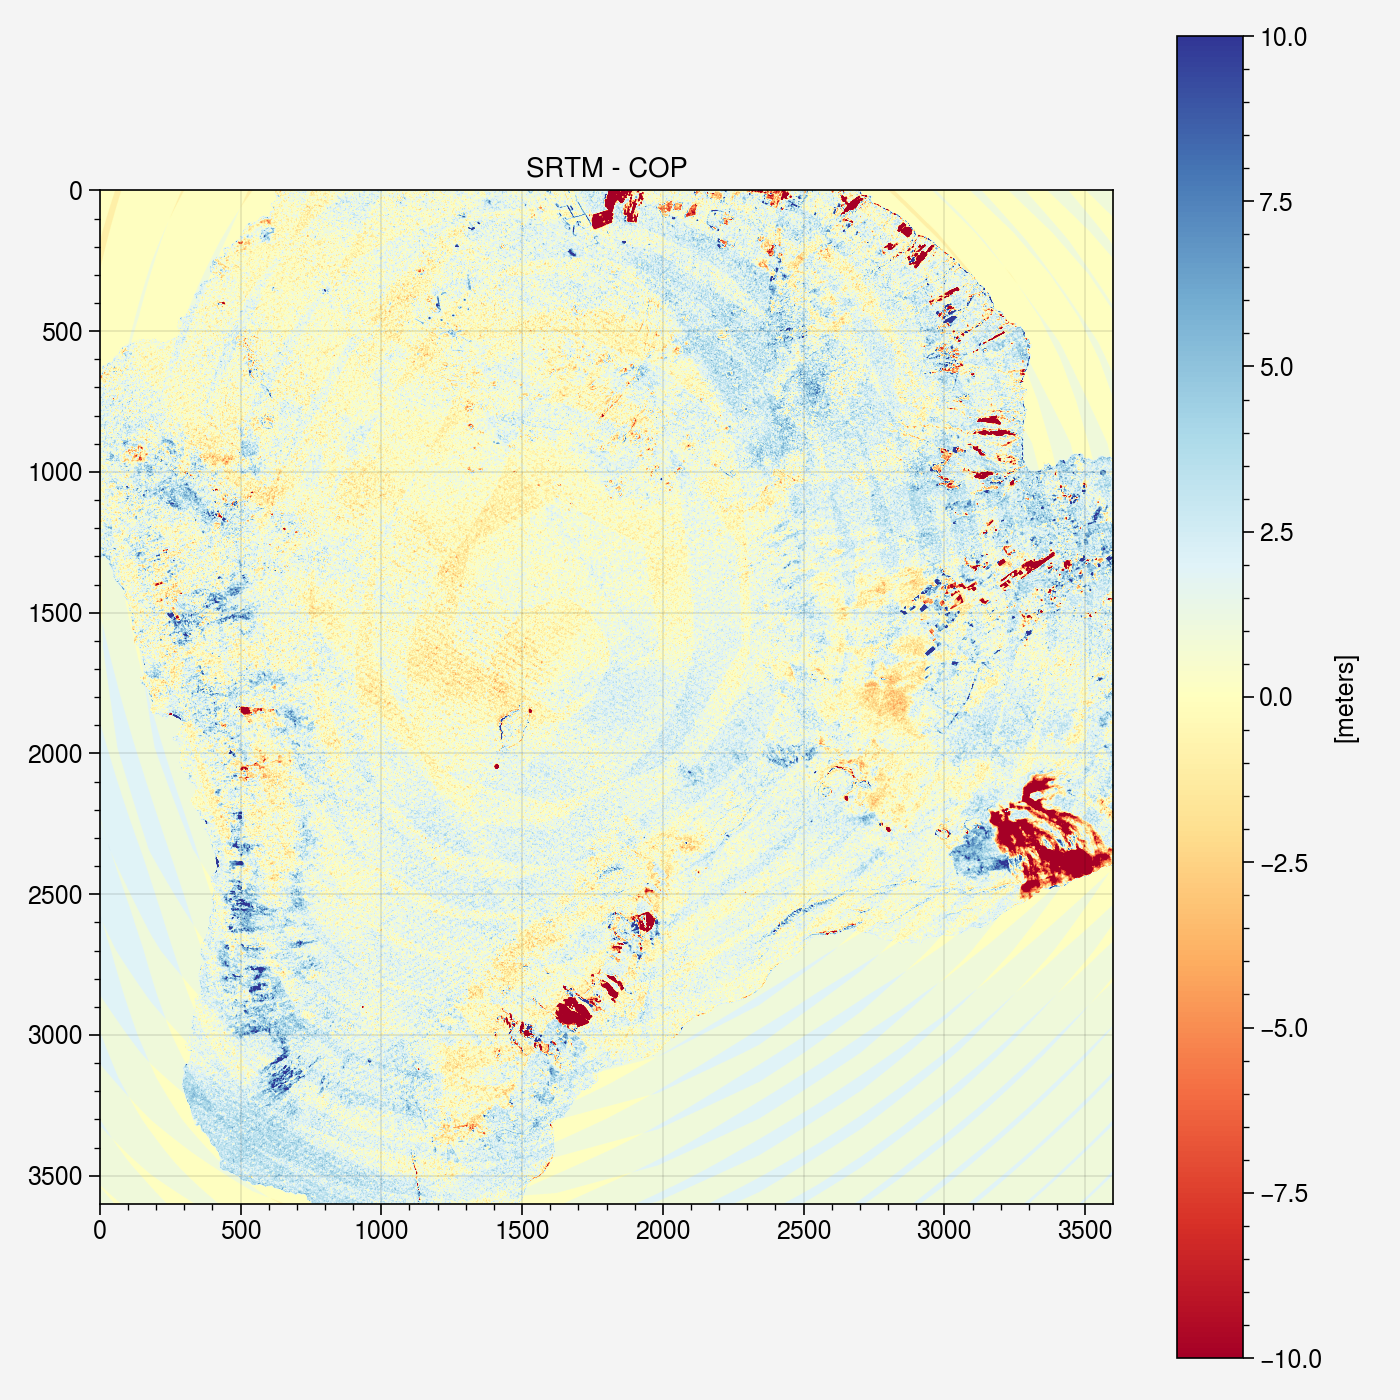

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 7))
axim = ax.imshow(dem_srtm - dem_cop, vmin=-10, vmax=10, cmap="RdYlBu")
cbar = fig.colorbar(axim)
cbar.set_label("[meters]")
ax.set_title("SRTM - COP")
fig.tight_layout()

Some notes on this difference image:

1. The circular rings of about +/-1 are likely due to differences in the two Geoids:

- egm96: 5773,  https://epsg.io/5773 , used as the vertical datum for the SRTM data
- egm2008: 3855,  https://epsg.io/3855 , used as the vertical datum for the COP data

2. On the right side of the image, the red ">-10 meter" values shows the lava flows from Kilauea's eruption through 2018, which added significant height to the area: https://www.nps.gov/havo/learn/nature/kilauea.htm

3. Some of the smaller patches which show >5 meters heigh difference are likely due to the SRTM being a DEM and the COP DEM actually being a DSM (digital surface model, https://gis.stackexchange.com/questions/5701/differences-between-dem-dsm-and-dtm)


More about the COP data hosted on AWS: https://copernicus-dem-30m.s3.amazonaws.com/readme.html

# Comparing the conversion from EGM2008 to WGS84 using geoidgrids

An earlier version of `sardem` used the `+geoidgrids`. Currently, we make the correction by specifying a compound CRS using horizontal+vertical EPSG codes:

Since the WGS84 EPSG code is 4326, we can specify the source as "EPSG:4326+5773" and the target as "EPSG:4326".

(see text for target source option of `gdalwarp`: https://gdal.org/programs/gdalwarp.html#cmdoption-gdalwarp-t_srs )

In [8]:
%%time
!gdalwarp -s_srs "+proj=longlat +datum=WGS84 +no_defs +geoidgrids=/Users/staniewi/.cache/sardem/egm08_25.gtx" -t_srs "+proj=longlat +datum=WGS84 +no_defs" /vsicurl/https://raw.githubusercontent.com/scottstanie/sardem/master/sardem/data/cop_global.vrt test_geoidgrid.dem -of ENVI -ot Int16 -te -156.000138888888898 19.0001388888888876 -155.000138888888898 20.0001388888888876 -tr 0.000277777777777777778 0.000277777777777777778

Creating output file that is 3600P x 3600L.
Processing /vsicurl/https://raw.githubusercontent.com/scottstanie/sardem/master/sardem/data/cop_global.vrt [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
CPU times: user 462 ms, sys: 174 ms, total: 636 ms
Wall time: 1min 4s


Note the difference in times:
- EPSG version ran in ~10 seconds
- Geoidgrid version ran in 64 seconds

The difference becomes more extreme for DEMs larger than 1 tile.

In [9]:
ds = gdal.Open("test_geoidgrid.dem")
dem_cop_geoid = ds.GetRasterBand(1).ReadAsArray()
ds = None

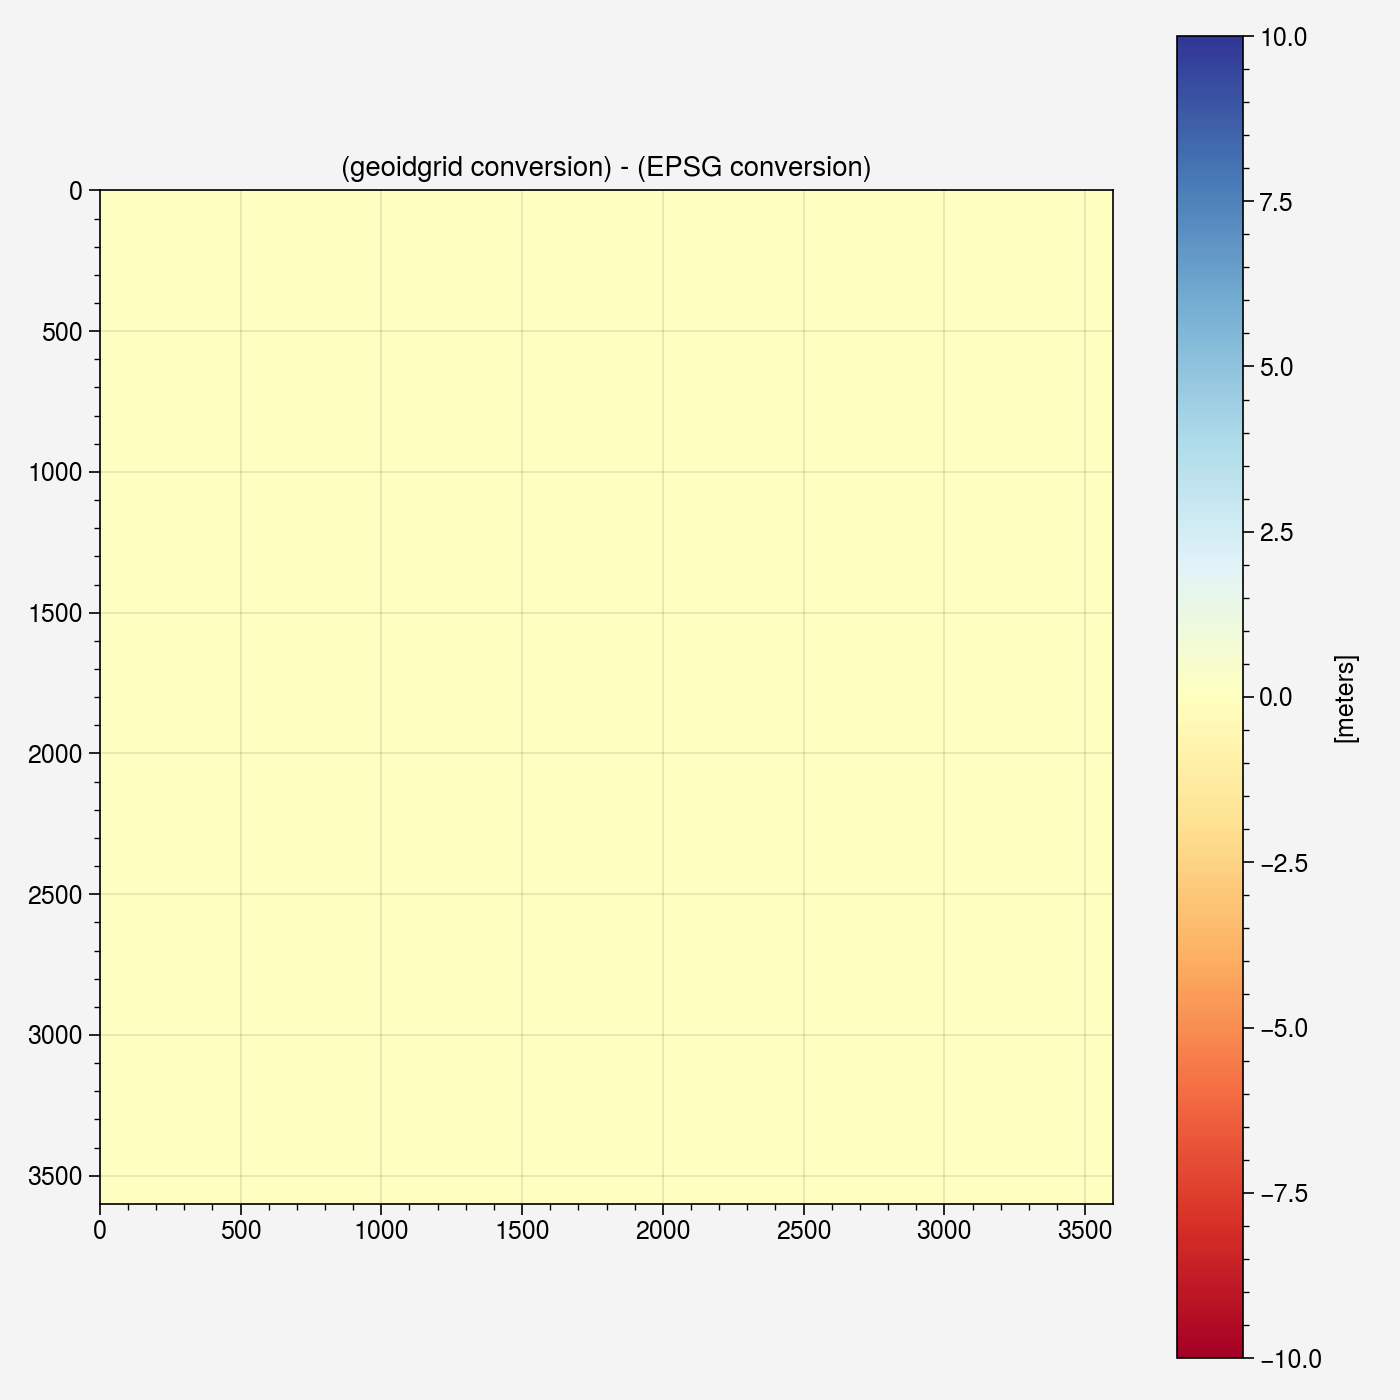

In [11]:
fig, ax = plt.subplots(figsize=(7, 7))
axim = ax.imshow(dem_cop_geoid - dem_cop, vmin=-10, vmax=10, cmap="RdYlBu")
cbar = fig.colorbar(axim)
cbar.set_label("[meters]")
ax.set_title("(geoidgrid conversion) - (EPSG conversion)")
fig.tight_layout()